In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from typing import cast

import numpy as np

from pretrain_braindecode_models.modeling.plotting import plot_history
from pretrain_braindecode_models.utils.custom_types import TrainingHistory

In [108]:
def generate_dummy_history(
    num_epochs: int,
    num_metrics: int = 2,
    *,
    include_lr: bool = False,
    outlier_epoch: int | None = None,
    outlier_value: float = 100.0,
    lr_schedule_type: str = "cosine",
    seed: int = 42,
) -> TrainingHistory:
    """Generate a plausible-looking dummy TrainingHistory dictionary."""
    rng = np.random.default_rng(seed)
    epochs = np.arange(num_epochs)

    # Generate realistic loss curves (exponential decay with noise)
    train_loss = 0.8 * np.exp(-epochs / (num_epochs / 4)) + rng.normal(0, 0.02, num_epochs) + 0.1
    val_loss = 1.0 * np.exp(-epochs / (num_epochs / 3)) + rng.normal(0, 0.03, num_epochs) + 0.15

    # Add an outlier if specified
    if outlier_epoch is not None and 0 <= outlier_epoch < num_epochs:
        train_loss[outlier_epoch] = outlier_value

    history: TrainingHistory = {
        "train_loss": train_loss.tolist(),
        "val_loss": val_loss.tolist(),
    }

    # Generate metric curves (logistic growth with noise)
    for i in range(num_metrics):
        metric_name = f"Metric {i + 1}"
        train_metric = 0.9 / (
            1 + np.exp(-(epochs - num_epochs / 2.5) / (num_epochs / 10))
        ) - rng.normal(0, 0.02, num_epochs)
        val_metric = 0.85 / (
            1 + np.exp(-(epochs - num_epochs / 2) / (num_epochs / 8))
        ) - rng.normal(0, 0.03, num_epochs)
        history[f"train_{metric_name}"] = np.clip(train_metric, 0, 1).tolist()
        history[f"val_{metric_name}"] = np.clip(val_metric, 0, 1).tolist()

    # Generate learning rate schedule
    if include_lr:
        if lr_schedule_type == "cosine":
            history["lr"] = (0.001 * (1 + np.cos(np.pi * epochs / num_epochs)) / 2).tolist()
        elif lr_schedule_type == "step":
            lr = np.full(num_epochs, 0.001)
            lr[num_epochs // 3 :] = 0.0001
            lr[2 * num_epochs // 3 :] = 0.00001
            history["lr"] = lr.tolist()

    return history

## **1. Basic Plotting**

### 1.1 Plotting 100 epochs

1.1: Simple Loss Plot (100 Epochs)
No non overlapping boxes found in direction east


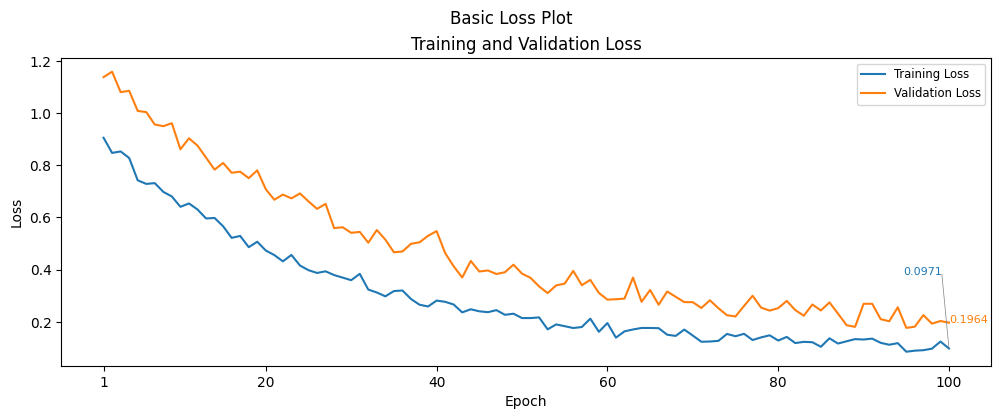

In [109]:
print("1.1: Simple Loss Plot (100 Epochs)")
history_100 = generate_dummy_history(100, num_metrics=0)
plot_history(
    history_100,
    figtitle="Basic Loss Plot",
    y_figtitle=1.0,
)

### 1.2 Plotting an uneven number of epochs (51)

2025-08-27 16:21:52.239 | DEBUG    | eeg_3d_face.modeling.plotting:_format_xaxis_epoch_ticks:21 - Removed crowded tick 50 because it was too close to the final epoch 51 (threshold: 2.5 epochs).


1.1: Simple Loss Plot (51 Epochs)
No non overlapping boxes found in direction east


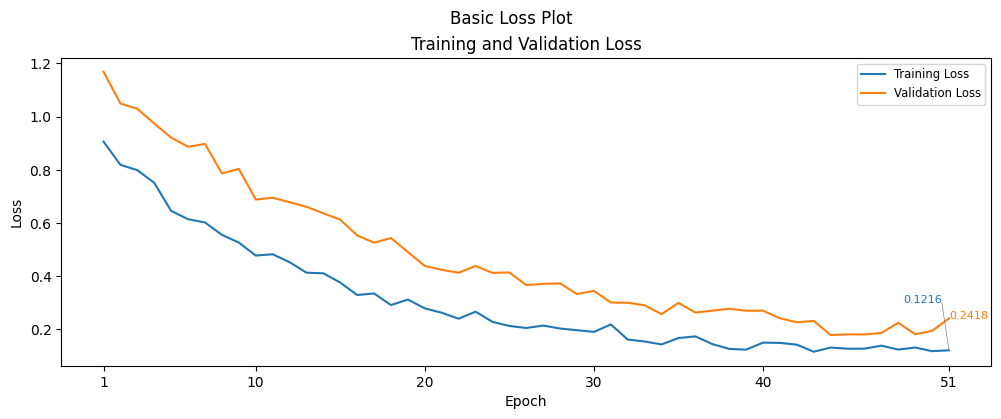

In [110]:
print("1.1: Simple Loss Plot (51 Epochs)")
history_100 = generate_dummy_history(51, num_metrics=0)
plot_history(
    history_100,
    figtitle="Basic Loss Plot",
    y_figtitle=1.0,
)

## **2. Plotting with Metrics**

2.1: Loss Plot with Metrics
No non overlapping boxes found in direction east
No non overlapping boxes found in direction east
No non overlapping boxes found in direction east


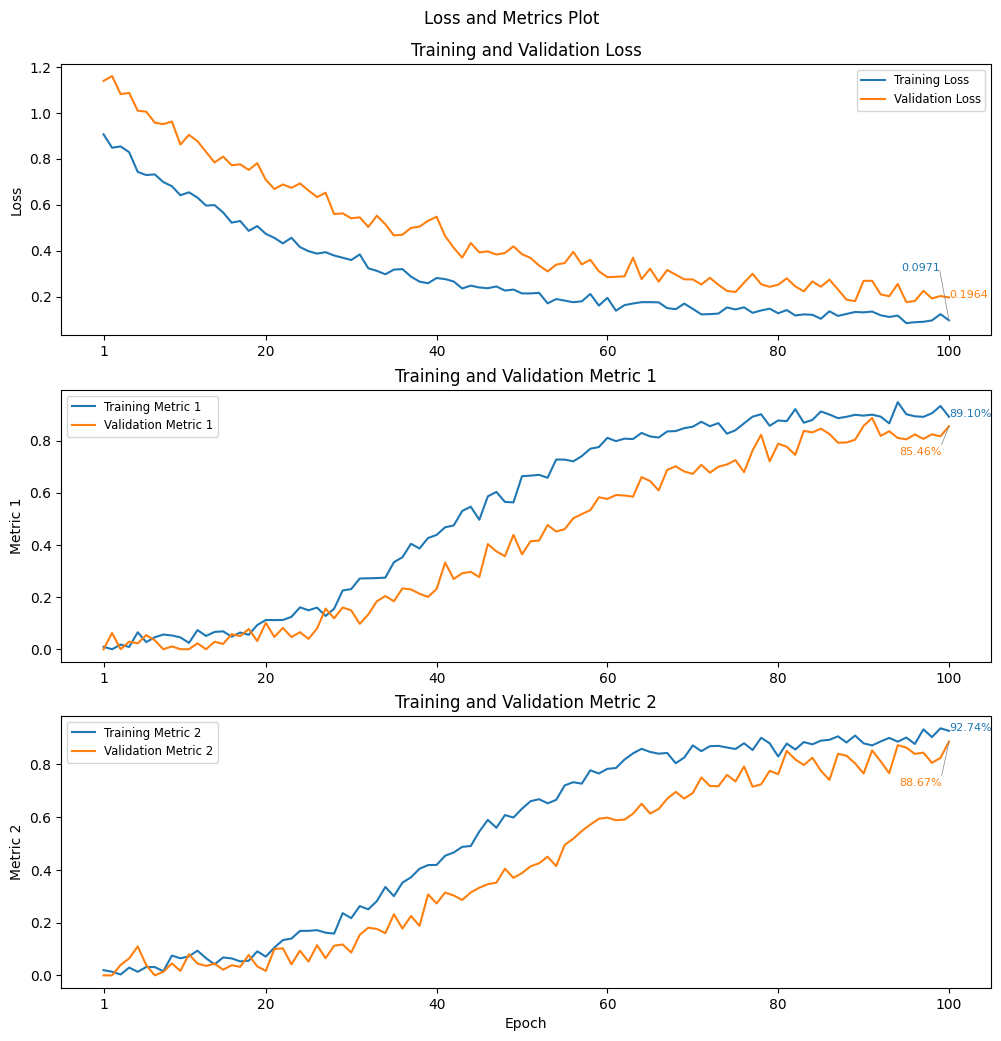

In [111]:
print("2.1: Loss Plot with Metrics")
history_with_metrics = generate_dummy_history(100, num_metrics=2)
plot_history(history_with_metrics, figtitle="Loss and Metrics Plot", y_figtitle=0.925)

## **3. Plotting with Learning Rate**

### 3.1 Cosine Annealing LR Schedule

3.1: Cosine Annealing LR Schedule


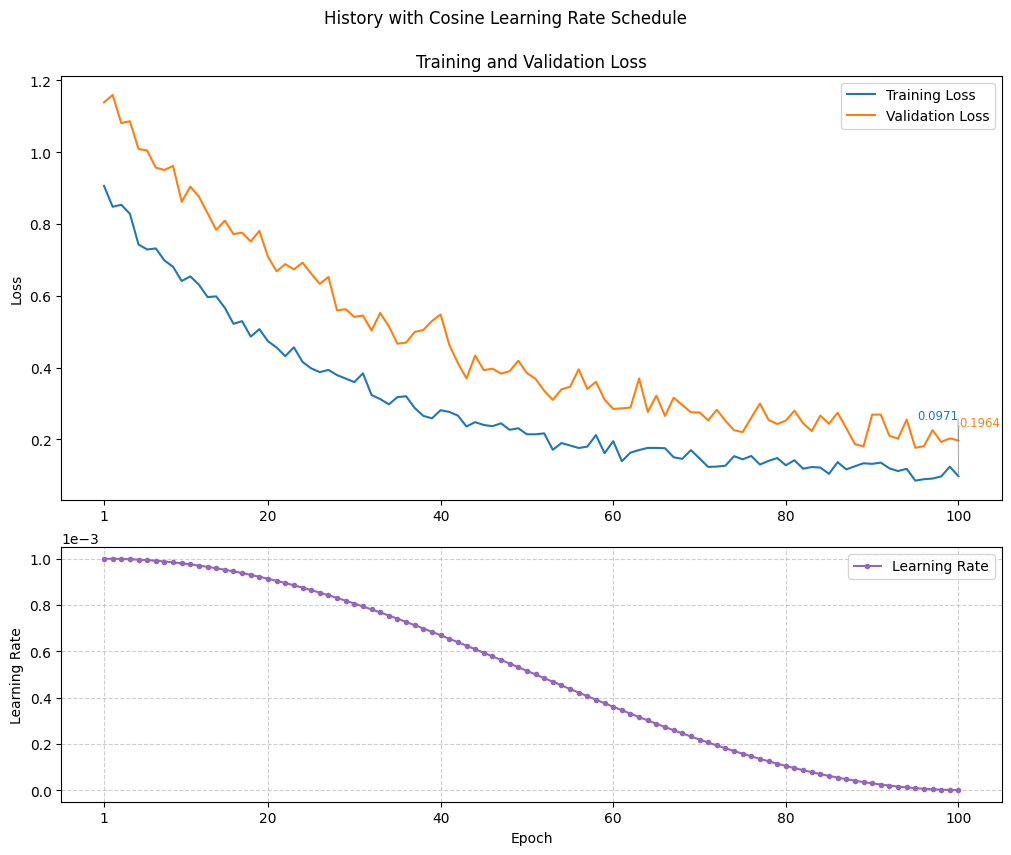

In [112]:
print("3.1: Cosine Annealing LR Schedule")
history_with_lr = generate_dummy_history(
    100,
    num_metrics=0,
    include_lr=True,
    lr_schedule_type="cosine",
)
plot_history(
    history_with_lr,
    figtitle="History with Cosine Learning Rate Schedule",
    y_figtitle=1.05,
    figsize=(10, 8),
    text_fontsize="small",
    legend_fontsize="medium",
)

### 3.2 Step LR Schedule

3.2: Step LR Schedule
No non overlapping boxes found in direction east
No non overlapping boxes found in direction east


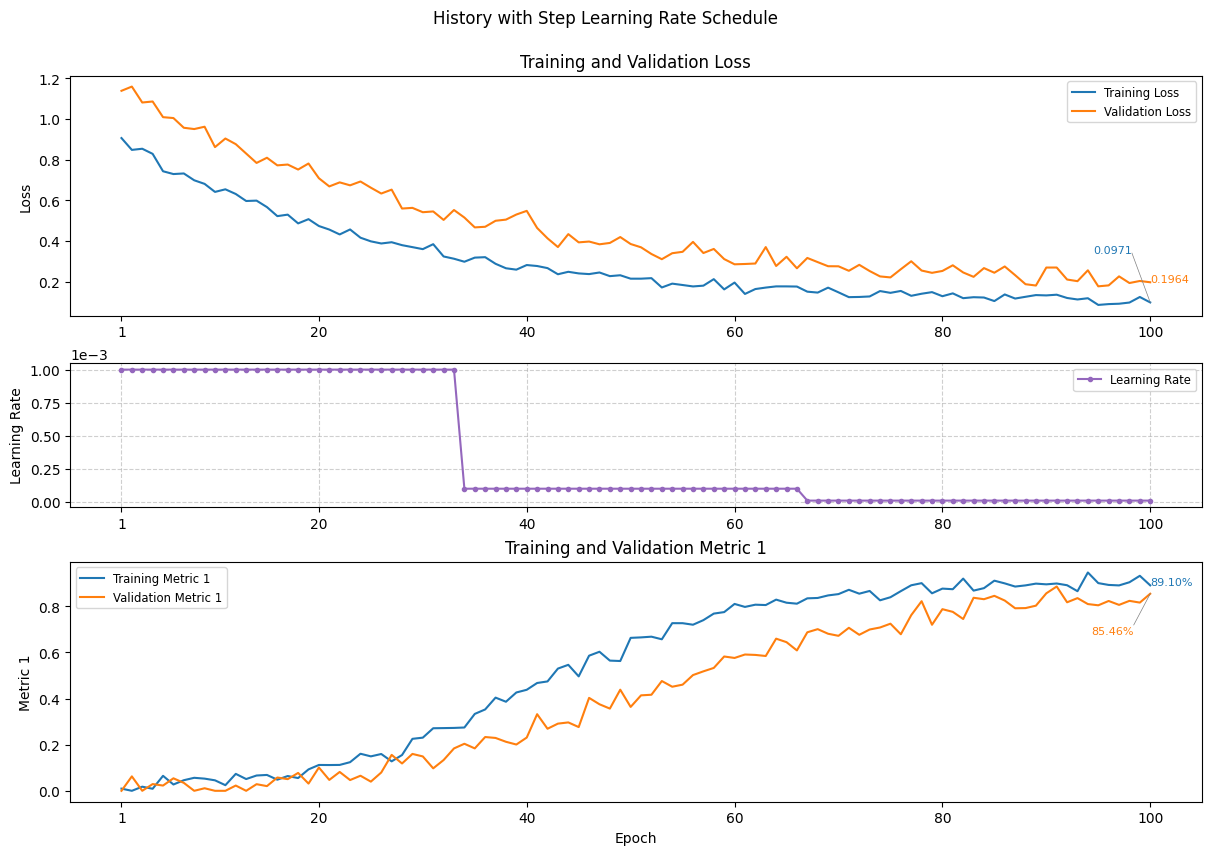

In [113]:
print("3.2: Step LR Schedule")
history_step_lr = generate_dummy_history(
    100,
    num_metrics=1,
    include_lr=True,
    lr_schedule_type="step",
)
plot_history(
    history_step_lr,
    figtitle="History with Step Learning Rate Schedule",
    y_figtitle=1.05,
)

## **4. Handling Outliers with Dynamic Clipping**

### 4.1: Plot with a Large Outlier (No Clipping)

4.1: Plot with a Large Outlier (No Clipping)
No non overlapping boxes found in direction east
No non overlapping boxes found in direction east


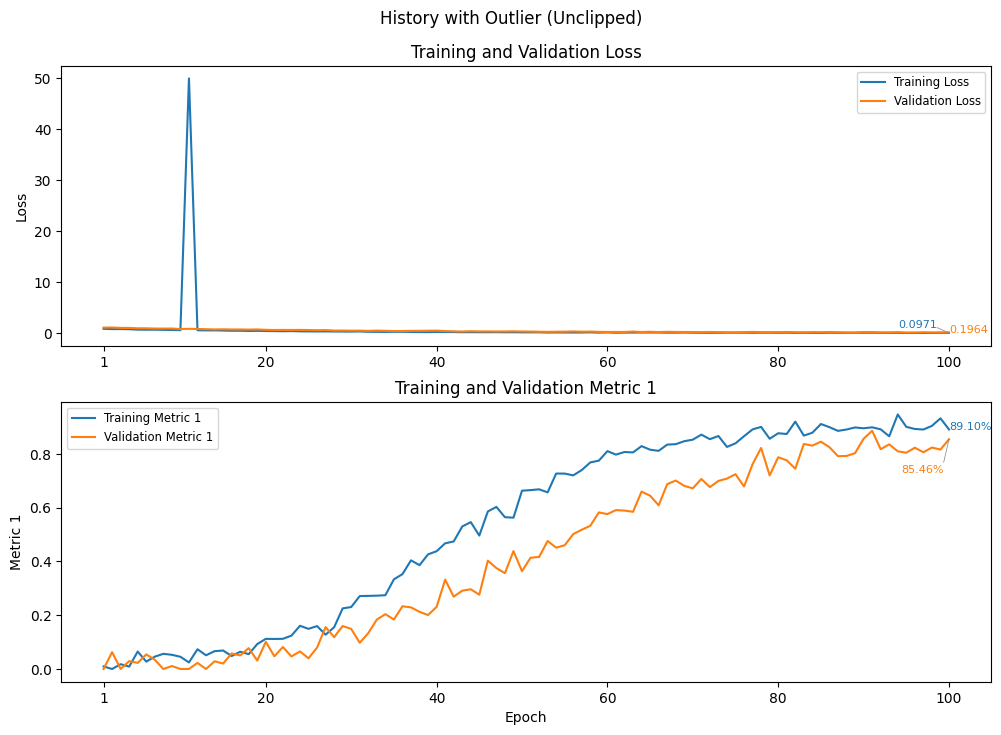

In [114]:
print("4.1: Plot with a Large Outlier (No Clipping)")
history_outlier = generate_dummy_history(100, num_metrics=1, outlier_epoch=10, outlier_value=50.0)
plot_history(history_outlier, figtitle="History with Outlier (Unclipped)", y_figtitle=0.95)

### 4.2: Same Plot with Dynamic Clipping Enabled

4.2: Same Plot with Dynamic Clipping Enabled
No non overlapping boxes found in direction east
No non overlapping boxes found in direction east


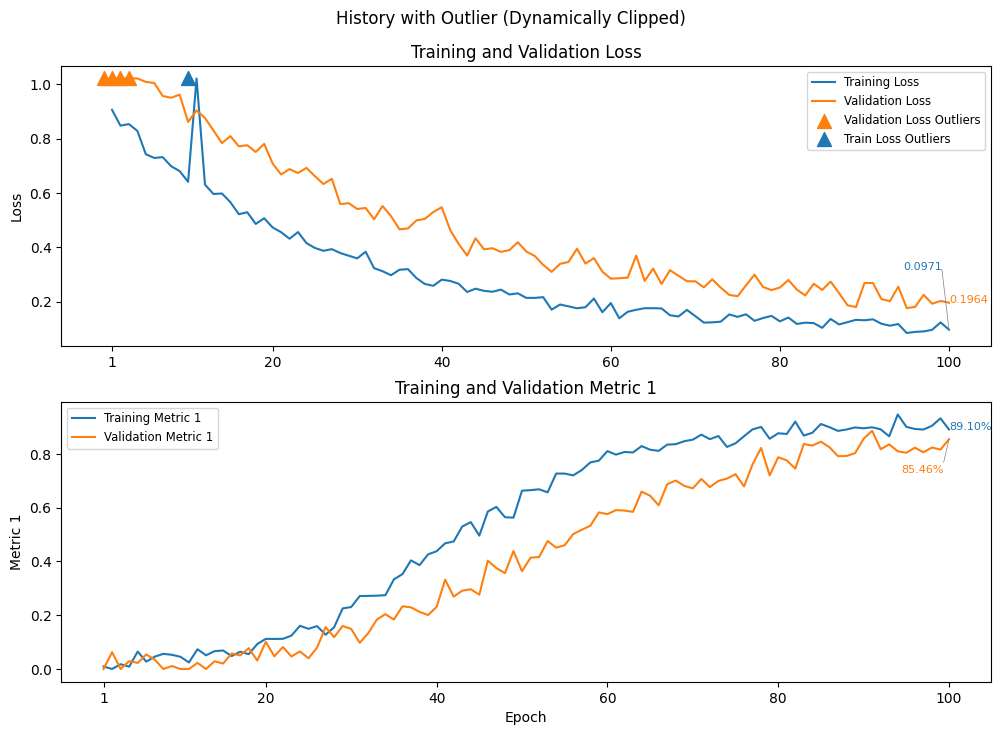

In [115]:
print("4.2: Same Plot with Dynamic Clipping Enabled")
plot_history(
    history_outlier,
    figtitle="History with Outlier (Dynamically Clipped)",
    dynamic_clip_iqr_multiplier=1.5,  # Standard multiplier for outliers
    y_figtitle=0.95,
)


## **5. Indicating Best/Early Stop Epoch**

5.1: Highlighting the Best Epoch
Best Epoch (0-based index): 94
No non overlapping boxes found in direction east
No non overlapping boxes found in direction east


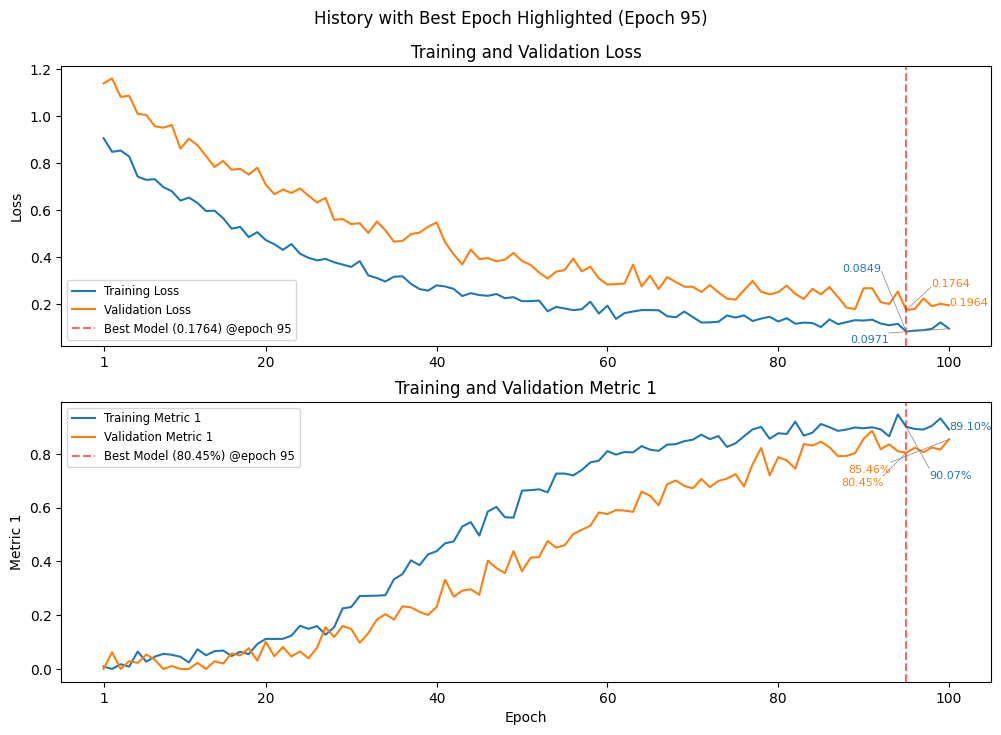

In [116]:
print("5.1: Highlighting the Best Epoch")
history_100 = generate_dummy_history(100, num_metrics=1)

# Find the actual best epoch from the validation loss
best_epoch = int(np.argmin(history_100["val_loss"]))
print("Best Epoch (0-based index):", best_epoch)
plot_history(
    history_100,
    overall_best_epoch=best_epoch,
    figtitle=f"History with Best Epoch Highlighted (Epoch {best_epoch + 1})",
    y_figtitle=0.95,
)

## **6. Using Logarithmic Scale**

6.1: Loss on a Logarithmic Scale
No non overlapping boxes found in direction east
No non overlapping boxes found in direction east


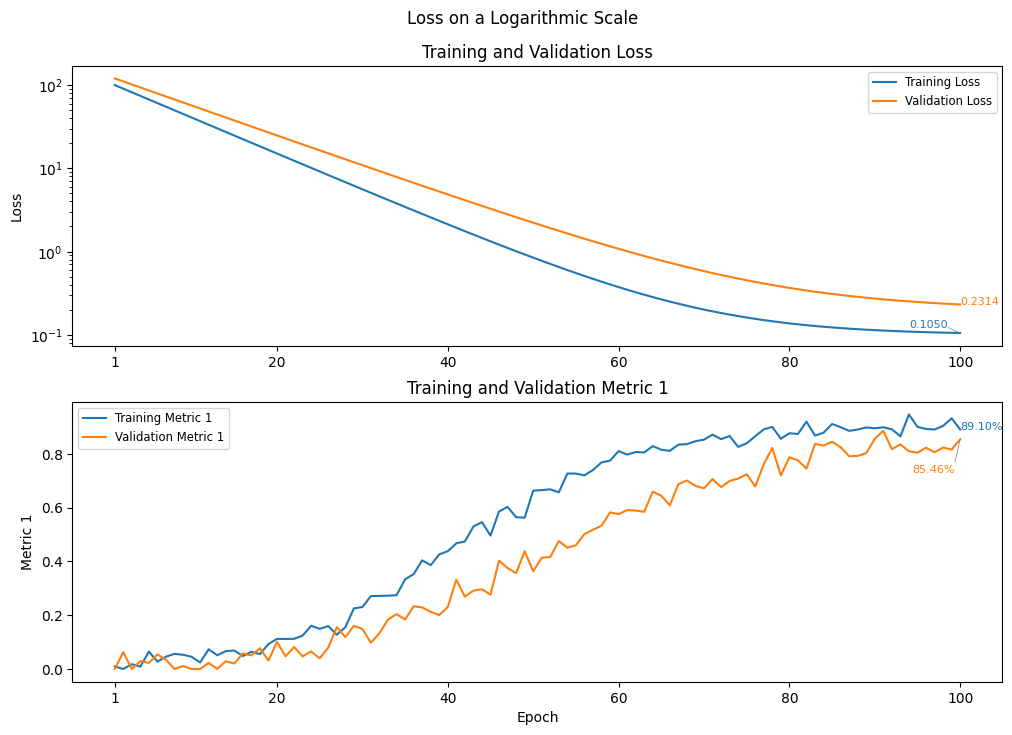

In [117]:
print("6.1: Loss on a Logarithmic Scale")

# Generate data with a large dynamic range
history_log = generate_dummy_history(100, num_metrics=1)
history_log["train_loss"] = (100 * np.exp(-np.arange(100) / 10) + 0.1).tolist()
history_log["val_loss"] = (120 * np.exp(-np.arange(100) / 12) + 0.2).tolist()

plot_history(
    history_log,
    log_scale_loss=True,
    figtitle="Loss on a Logarithmic Scale",
    y_figtitle=0.95,
)

## **7. Visualizing a 3-Phase Training Run**

7.1: Visualizing a 3-Phase Training Run
No non overlapping boxes found in direction east
No non overlapping boxes found in direction east


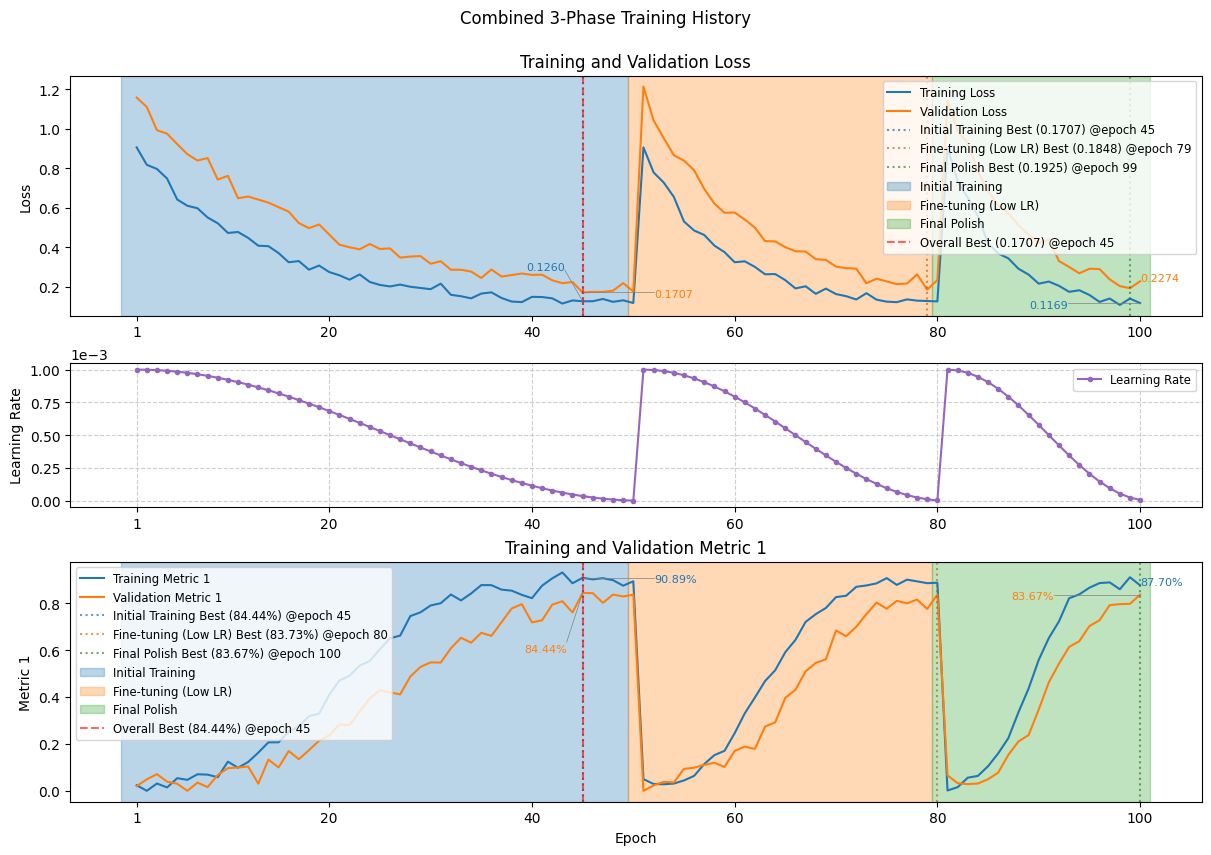

In [118]:
print("7.1: Visualizing a 3-Phase Training Run")

# Phase 1: 50 epochs
history_p1 = generate_dummy_history(50, include_lr=True)
# Phase 2: 30 epochs
history_p2 = generate_dummy_history(30, include_lr=True)
# Phase 3: 20 epochs
history_p3 = generate_dummy_history(20, include_lr=True)

# Combine histories
combined_history = {
    key: history_p1.get(key, []) + history_p2.get(key, []) + history_p3.get(key, [])
    for key in set(history_p1.keys()) | set(history_p2.keys()) | set(history_p3.keys())
}

phase_info = [
    ("Initial Training", 50),
    ("Fine-tuning (Low LR)", 30),
    ("Final Polish", 20),
]

# --- Cast the dictionary to the correct type ---
combined_history = cast("TrainingHistory", combined_history)

# Find the overall best epoch across all phases
overall_best_epoch = int(np.argmin(combined_history["val_loss"]))

plot_history(
    combined_history,
    metrics=["Metric 1"],
    is_combined=True,
    phase_info=phase_info,
    overall_best_epoch=overall_best_epoch,
    figtitle="Combined 3-Phase Training History",
    y_figtitle=1.05,
)